<h1>Brain Tumor Classification</h1>
<p>SVM model is implemented to classify and detect wether the MRI has a tumor or not and classify which type of tumor
<br>
The features were HOG + LBP + GLCM
</p>

In [1]:
# utility libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm

# image preprocessing libray
import cv2 as cv
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog
from skimage import morphology


# machine learnin model
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
HEIGHT = 128 #bisa coba 64
WIDTH = 128 #bisa coba 64
IMG_SIZE = (HEIGHT, WIDTH)

<h1>Reading Dataset</h1>

In [3]:
classification_path = "dataset/brisc2025/classification_task/train"
segmentation_path = "dataset/brisc2025/segmentation_task/train"


class loadDataset:
    def __init__(self):
       self.class_int = {}
       self.int_to_class = {}

    def readDataset(self, datapath, img_size):

        self.class_int = {}
        self.int_to_class = {}

        data = []
        labels = []

        for i, img_class in enumerate(sorted(os.listdir(datapath))):

            class_path = os.path.join(datapath, img_class)
            if not os.path.isdir(class_path):
                continue

            self.class_int[img_class] = i
            self.int_to_class[i] = img_class

            for img_path in tqdm(os.listdir(class_path)):

                true_path = os.path.join(datapath, img_class, img_path)

                # read image
                img = cv.imread(true_path)

                # resize imaga
                img = cv.resize(img, dsize=img_size, interpolation=cv.INTER_AREA)
                
                # save the image
                data.append(img)

                # 
                labels.append(i)

        return labels, data
    
    def mapLabel(self):
        
        return self.int_to_class



In [4]:
loader = loadDataset()
y, x = loader.readDataset(datapath=classification_path, img_size=IMG_SIZE)

100%|██████████| 1457/1457 [00:06<00:00, 227.29it/s]


In [5]:
print(f"Length of the dataset: {len(x)}\ndataset shape: {x[0].shape}")

Length of the dataset: 5000
dataset shape: (128, 128, 3)


<h1>Preprocessing Image</h1>

In [6]:
class Preprocessor():
    def __init__(self, ksize=(3, 3), clip_limit=2.0, tile_size=(4, 4)):
        self.ksize = ksize
        self.clip_limit = clip_limit
        self.tile_size = tile_size
        self.clahe = cv.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_size)

    def process_img(self, data):
        
        transformed_data = []

        for img in tqdm(data):

            # grayscale
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            # smoothing first
            smoothed = cv.GaussianBlur(gray, ksize=self.ksize, sigmaX=0)

            # enhanced using CLAHE
            enhanced = self.clahe.apply(smoothed)

            transformed_data.append(enhanced)

        return transformed_data



In [7]:
def visualize(img, title=None):

    plt.figure(figsize=(9, 6))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

In [8]:
preprocess = Preprocessor()
x_preprocessed = preprocess.process_img(x)

100%|██████████| 5000/5000 [00:00<00:00, 5212.76it/s]


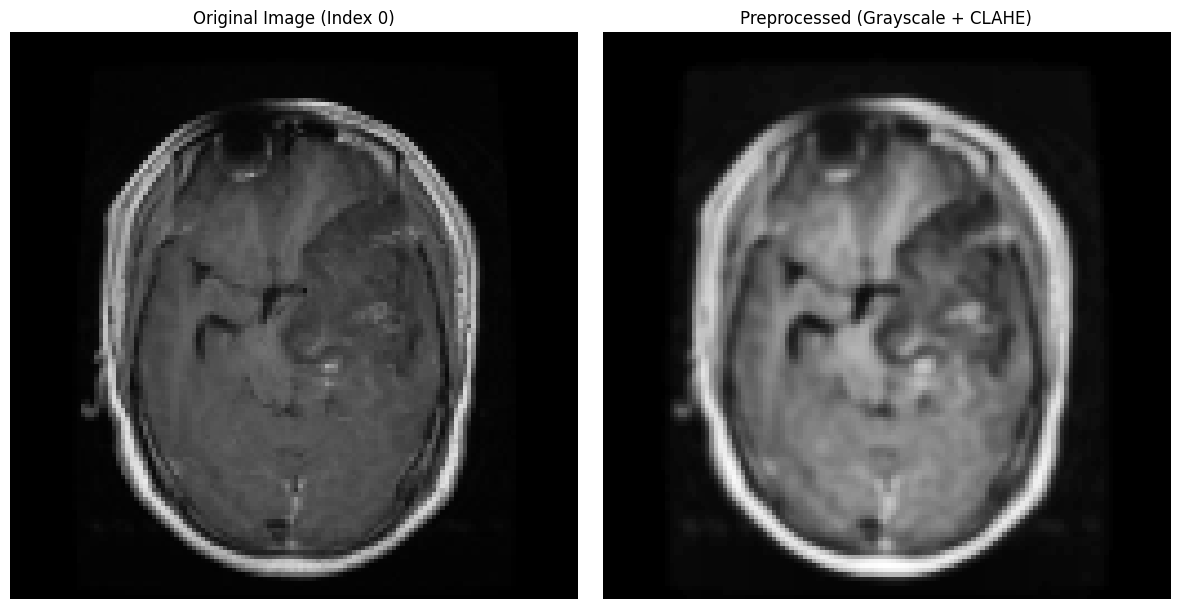

In [ ]:
def visualize_comparison(original, preprocessed, idx=0):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(original[idx], cv.COLOR_BGR2RGB))
    plt.title(f"Original Image (Index {idx})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed[idx], cmap='gray')
    plt.title("Preprocessed (Grayscale + CLAHE)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
print(f"Dataset length: {len(x_preprocessed)}\nDataset shape: {x_preprocessed[0].shape}")

Dataset length: 5000
Dataset shape: (128, 128)


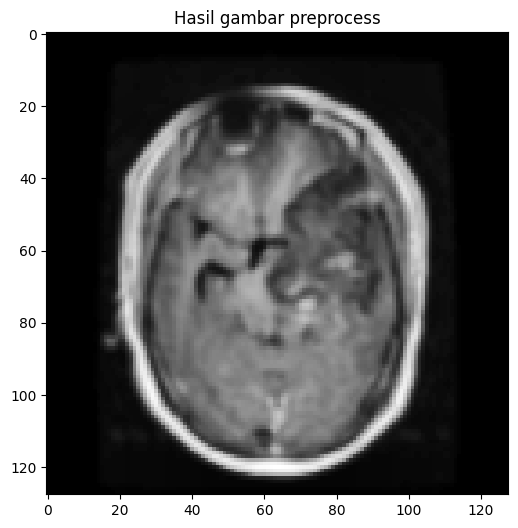

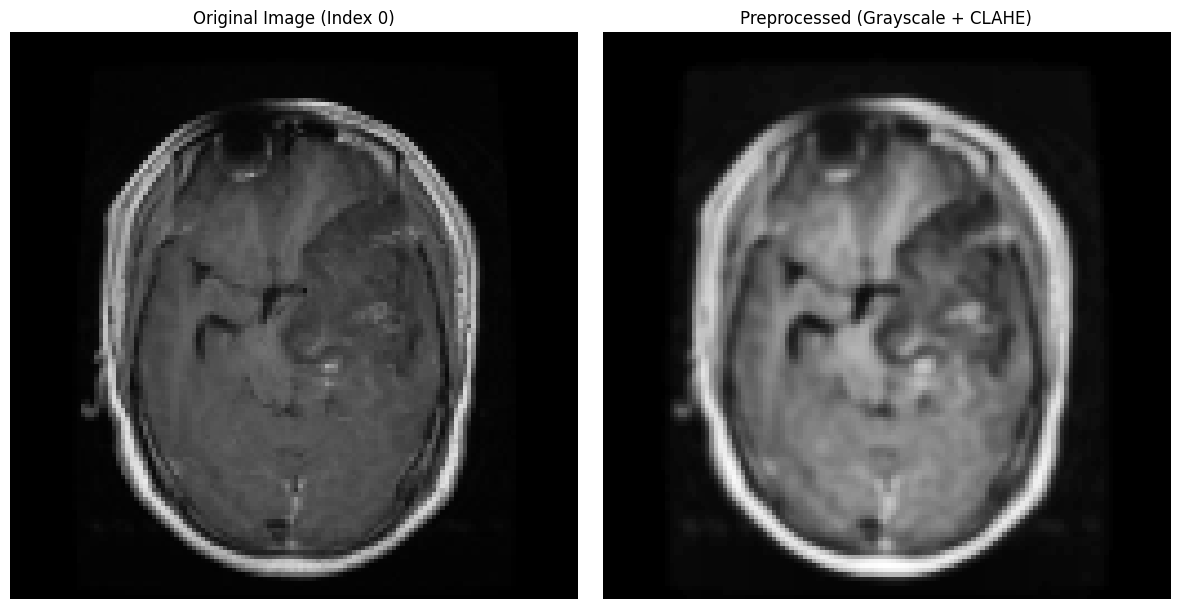

In [16]:
visualize(x_preprocessed[0], title='Hasil gambar preprocess')
visualize_comparison(x, x_preprocessed, idx=0)

<h1>Extract Features</h1>

In [14]:
class ExtractFeature:
    def __init__(self):
        pass
    
    def statistical_feature(self, img):
        mean = np.mean(img)
        std = np.std(img)
        median = np.median(img)
        f_stats = np.array([mean, std, median])

        return f_stats
    
    def glcm_feature(self, img):
        img_glcm = img.astype(np.uint8)

        glcm = graycomatrix(img_glcm,
                            distances=[1],
                            angles=[0],
                            levels=256,
                            symmetric=True,
                            normed=True
                            )
        
        f_contrast = graycoprops(glcm, 'contrast')[0, 0]
        f_energy = graycoprops(glcm, 'energy')[0, 0]
        f_homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        f_correlation = graycoprops(glcm, 'correlation')[0, 0]
        f_glcm = np.array([f_contrast, f_energy, f_homogeneity, f_correlation])

        return f_glcm
    

    def lbp_feature(self, img):
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        
        f_lbp, _ = np.histogram(lbp.ravel(),
                                bins=np.arange(0, n_points + 3),
                                range=(0, n_points + 2),
                                density=True)
        return f_lbp
    

    def hog_feature(self, img):
        img_norm = img / 255.0 if img.max() > 1.0 else img

        f_hog = hog(img_norm, 
                    orientations=9, 
                    pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), 
                    transform_sqrt=True, 
                    block_norm='L2-Hys',
                    visualize=False)

        return f_hog
    
    def extract_all_features(self, img):
        f_stats = self.statistical_feature(img)
        f_glcm = self.glcm_feature(img)
        f_lbp = self.lbp_feature(img)
        f_hog = self.hog_feature(img)
    
        combined_features = np.hstack([f_glcm, f_lbp, f_hog])
        
        return combined_features

In [15]:
x_features = []
extractor = ExtractFeature()

for img in tqdm(x_preprocessed):
    features = extractor.extract_all_features(img)

    x_features.append(features)

100%|██████████| 5000/5000 [00:47<00:00, 104.94it/s]


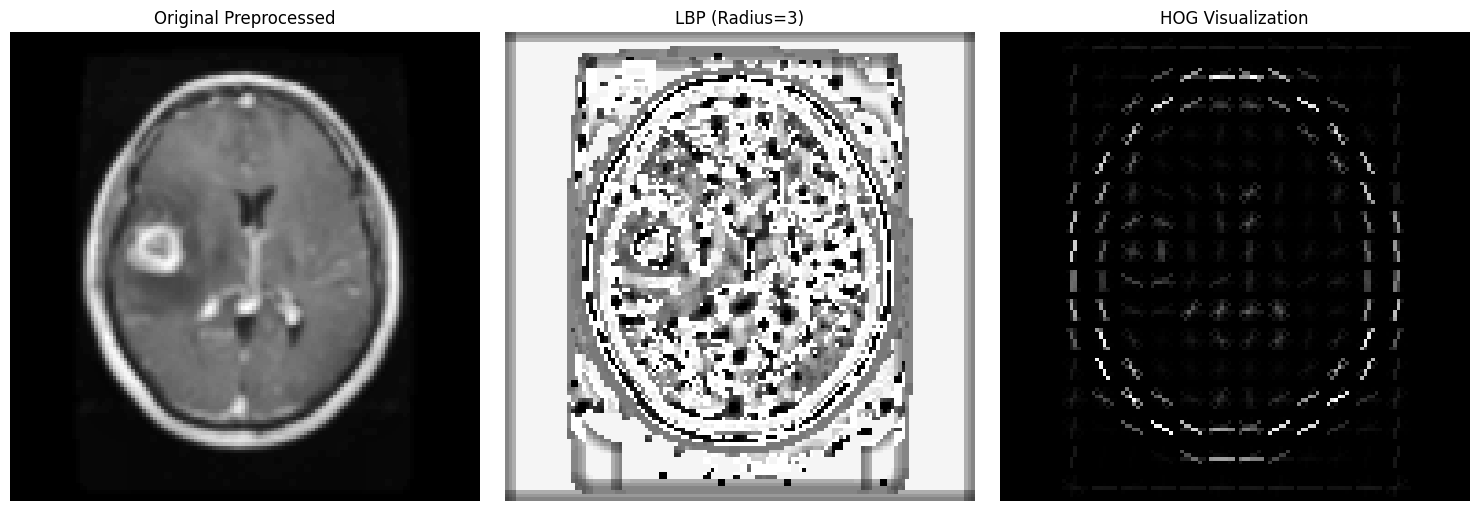

In [ ]:
def visualize_features(img, title="Feature Visualization"):
    if len(img.shape) > 2:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        gray = img

    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

    _, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=True, transform_sqrt=True)

    plt.figure(figsize=(15, 5))

    # Gambar Asli
    plt.subplot(1, 3, 1)
    plt.imshow(gray, cmap='gray')
    plt.title("Original Preprocessed")
    plt.axis('off')

    # LBP
    plt.subplot(1, 3, 2)
    plt.imshow(lbp, cmap='gray')
    plt.title(f"LBP (Radius={radius})")
    plt.axis('off')

    # HOG
    plt.subplot(1, 3, 3)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG Visualization")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_features(x_preprocessed[2]) 

<h1>Preparing Training Data</h1>

In [25]:
# preparing labels and data
x_features = np.array(x_features)
y = np.array(y)


# splitting data training and test

x_train, x_test, y_train, y_test = train_test_split(x_features, y, random_state=42)

scalerx = StandardScaler()

x_train_scaled = scalerx.fit_transform(x_train)
x_test_scaled = scalerx.transform(x_test)



<h1>Training Model SVC</h1>

In [26]:
svc_model = SVC(C=1, kernel='rbf')
tqdm(svc_model.fit(X=x_train_scaled, y=y_train))

0it [00:00, ?it/s]

<h1>Evaluate Model SVC</h1>

In [27]:
y_pred = svc_model.predict(x_test_scaled)

acc = accuracy_score(y_test, y_pred)

Accuracy model: 0.94
Confusion Matrix:


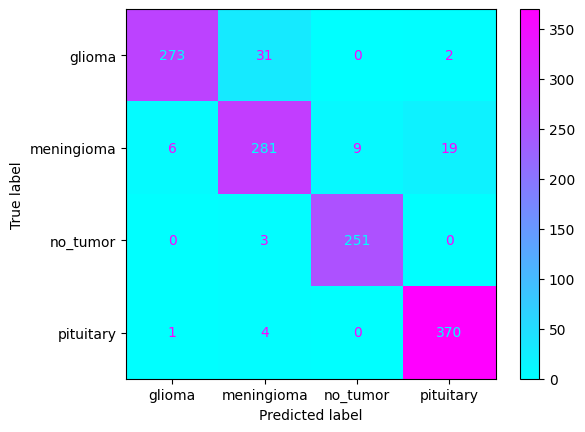

In [28]:
print(f"Accuracy model: {acc}")


cf_matrix = confusion_matrix(y_test, y_pred)
class_labels = loader.mapLabel()
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=list(class_labels.values()))

print("Confusion Matrix:")
disp.plot(cmap='cool')
plt.show()

In [ ]:
# filename = "svc_bt_classificatio_model.joblib"
# joblib.dump(svc_model, filename=filename)
# print(f"Saving model with name: {filename}")